In [6]:
#Load in relevant libraries
import math

import numpy as np

from astropy import units as u
from astropy import coordinates as coord
from astropy.coordinates import SkyCoord, ICRS, Galactocentric, Distance, LSR
from astropy.coordinates import FK5
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from astropy.table import Table, vstack, hstack
from astropy.table import Column
from astropy.io import ascii

import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic

from scipy import stats

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler, normalize

import time

import matplotlib.pyplot as plt

import pandas as pd

In [7]:
#Load in the table that contains halo with the clusters
t = Table.read('Step_3_Output.fits')
surv = Table.read('Step_6_Survivor.fits')
print("Total Number of Stars in Data Set: " + str(len(t)))
print("Total Number of Stars in Survivor Set: " + str(len(surv)))

#Load in the two synthetic databases to be combined, and refined
# to produce a synthetic halo set
syn_1 = Table.read('Galaxia_Synth_1.fits')
syn_2 = Table.read('Galaxia_Synth_2.fits')
syn_3 = Table.read('Galaxia_Synth_3.fits')
print("Total Number of Stars in Synthetic Set 1: " + str(len(syn_1)))
print("Total Number of Stars in Synthetic Set 2: " + str(len(syn_2)))
print("Total Number of Stars in Synthetic Set 3: " + str(len(syn_3)))

Total Number of Stars in Data Set: 6789
Total Number of Stars in Survivor Set: 36
Total Number of Stars in Synthetic Set 1: 14857486
Total Number of Stars in Synthetic Set 2: 14855281
Total Number of Stars in Synthetic Set 3: 14856369


In [3]:
#Program begins by combing the two synthetic surveys together
syn = vstack([syn_1,syn_2,syn_3])

#Synthetic distances are saved in units of kpc so they need to be converted
# to pc.
syn['r_dist'] = syn['r_dist']*1000*u.pc

#We then impose the < 1kpc restriction as was done in the Gaia database
syn = syn[(syn['r_dist']<1000)]

#We save the cartesian heliocentric positions provided by Galaxia as a coordinate object
c = ICRS(x=syn['x_val']*1000*u.pc,
                            y=syn['y_val']*1000*u.pc,
                            z=syn['z_val']*1000*u.pc,
                            v_x=syn['U']*u.km/u.s,
                            v_y=syn['V']*u.km/u.s,
                            v_z=syn['W']*u.km/u.s,
                            representation_type=CartesianRepresentation,
                            differential_type=CartesianDifferential)

#We transform the heliocentric coordinates to Galactocentric coordinates
qq = c.transform_to(Galactocentric)

#Create an empty table called gsyn to save the converted values into
gsyn = Table()

x_val =Column(qq.x, 'x_val')
y_val =Column(qq.y, 'y_val')
z_val =Column(qq.z, 'z_val')

U = Column(syn['U'], 'U')
V = Column(syn['V'], 'V')
W = Column(syn['W'], 'W')

gsyn.add_column(x_val)
gsyn.add_column(y_val)
gsyn.add_column(z_val)

gsyn.add_column(U)
gsyn.add_column(V)
gsyn.add_column(W)

x_val = gsyn['x_val']
y_val = gsyn['y_val']
z_val = gsyn['z_val']

U = gsyn['U']
V = gsyn['V']
W = gsyn['W']

#Using Pyyhagora theorem we find the total velocity and add it too the table
Vel = np.sqrt(U*U + V*V + W*W)
V_Tot = Column(Vel, name='V_LSR')
gsyn.add_column(V_Tot)

#We then apply the LSR restricition like we did with the Halo set. Note all the
# stars are already in a local standard of rest which means we don't need to 
#  subtract the V velocity values
gsyn = gsyn[(gsyn['V_LSR'] > 210)]

#We add the LSR velocity to the stars to have the same distribution as the Gaia set
gsyn['V'] = gsyn['V'] + 232

#We then calculate the actions for each of the synthetic stars.
x = gsyn['x_val']
y = gsyn['y_val']
z = gsyn['z_val']

U = gsyn['U']
V = gsyn['V']
W = gsyn['W']

#In order to calculate the actions, you need to specifiy a graviational potential. 
# In this case we use a combination of potentials in the same manner as Helmi et al 2017. 
#  Using the MilkyWayPotential class models the buldge, disk and halo in combination. 
pot = gp.MilkyWayPotential(units=galactic)

#We use the Gala function PhaseSpacePosition to save the 6-D phase space coordinates, which
# are taken from the above vectors,
w0 = gd.PhaseSpacePosition(pos=[x, y, z]*u.pc,
                           vel=[U, V, W]*u.km/u.s)

#The orbit of the star is then calculated using the following command for 1000 steps
orbit = gp.Hamiltonian(pot).integrate_orbit(w0, dt=1., n_steps=1000)

#First Calculate the energies of each orbit
E = orbit.energy().to(u.km*u.km/(u.s*u.s))
Energy = Column(E[0], name = 'Energy')
#trunc.add_column(Energy)

#Z-coomponent of angular momentum is calculated
Lz = orbit.angular_momentum()[2].to(u.km*u.kpc/u.s)
L_z = Column(Lz[0], name = 'Lz')
#trunc.add_column(L_z)

#The required conserved quantities are then extracted from the saved orbit paramerters.
Lx = orbit.angular_momentum()[0].to(u.km*u.kpc/u.s)
Ly = orbit.angular_momentum()[1].to(u.km*u.kpc/u.s)

#We calculcualte the poerpedicular component of the angular momentum
Lp = np.sqrt(Lx[0]*Lx[0]+Ly[0]*Ly[0])


L_perp = Column(Lp, name = 'L_perp')

T=Table()
T.add_column(Energy)
L_z=-L_z
T.add_column(L_z)
T.add_column(L_perp)


gsyn = hstack([gsyn,T])

#Randomly selects stars from the combined sample to equal that of the Gaia Dataset
gsyn = Table(np.random.choice(gsyn,len(t)))

print("Actions Calculated")
print("Total Number of Stars in Synthetic Set: " + str(len(gsyn)))

#Save the file of the Synthetic Dataset
gsyn.write('Step_7_Galaxia_Halo.fits', overwrite = True)   

Actions Calculated
Total Number of Stars in Synthetic Set: 6789


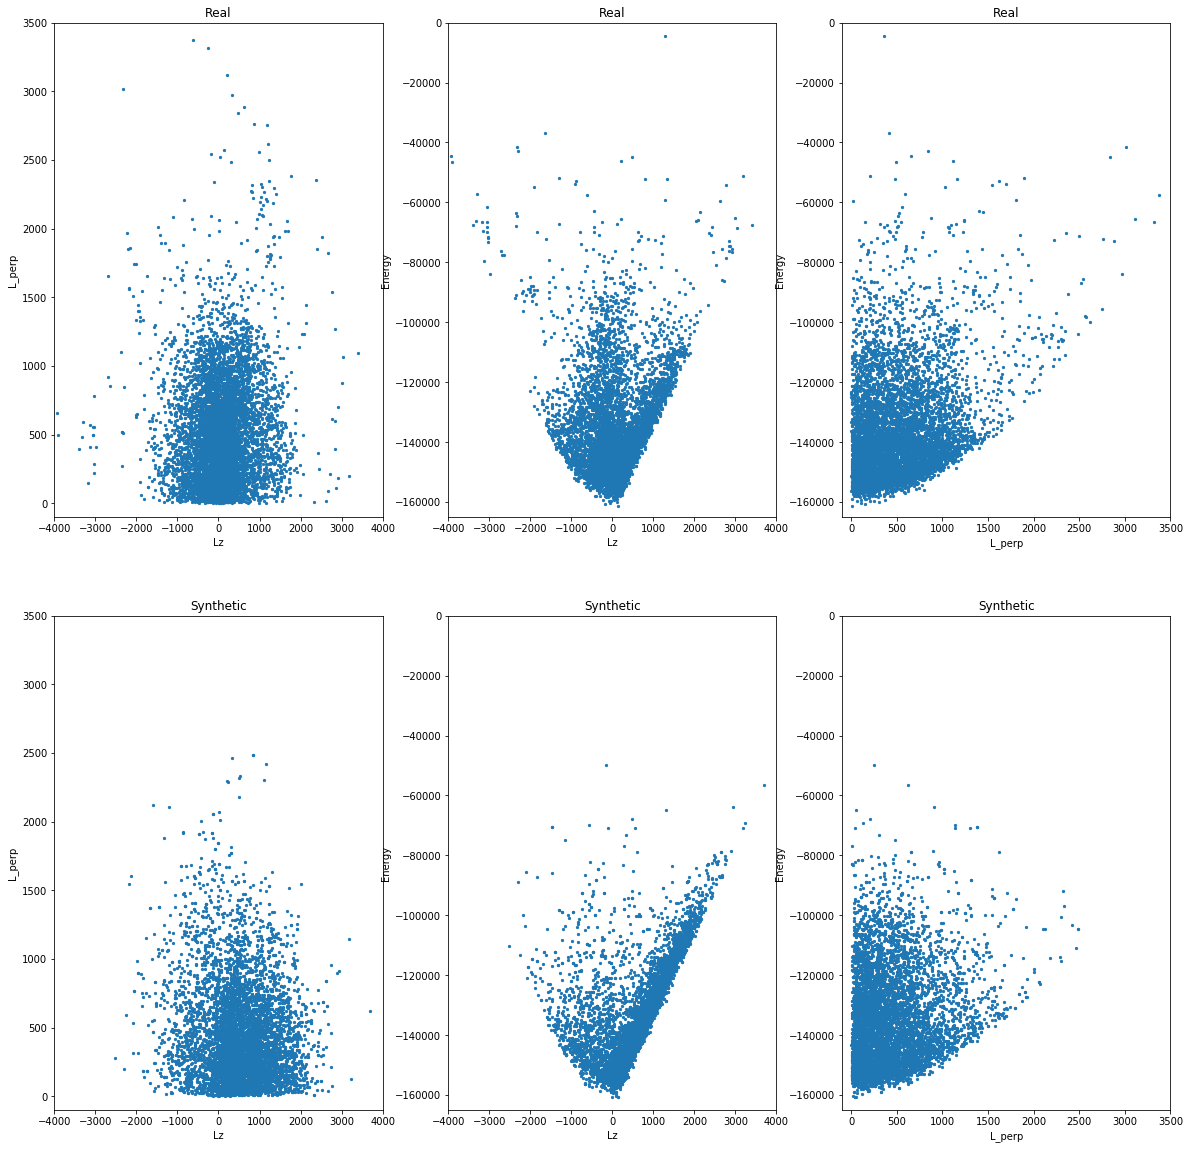

In [5]:
#We want to re-create the action space plots for comparison
plt.figure(figsize=(20,20))

t = t[t['V']<400]
t = t[t['Energy']<0]

#Variables to plot
A = 'Lz'
B = 'L_perp'
C = 'Energy'
D = 'Lz'
E = 'L_perp'
F = 'Energy'

#Lz vs L_perp plot in Real Space
plt.subplot(231)
plt.title('Real')
plt.xlabel(D)
plt.ylabel(E)
plt.ylim(top=3500, bottom=-100)
plt.xlim(left=-4000,right=4000)
plt.scatter(t[D],t[E],s=5)

#Lz vs Energy plot in Real Space
plt.subplot(232)
plt.title('Real')
plt.xlabel(D)
plt.ylabel(F)
plt.ylim(top=0, bottom=-165000)
plt.xlim(left=-4000,right=4000)
plt.scatter(t[D],t[F],s=5)

#L_perp vs Energy in Real Space
plt.subplot(233)
plt.title('Real')
plt.xlabel(E)
plt.ylabel(F)
plt.ylim(top=0, bottom=-165000)
plt.xlim(left=-100,right=3500)
plt.scatter(t[E],t[F],s=5)

#Lz vs L_perp plot in Synthetic Space
plt.subplot(234)
plt.title('Synthetic')
plt.xlabel(D)
plt.ylabel(E)
plt.ylim(top=3500, bottom=-100)
plt.xlim(left=-4000,right=4000)
plt.scatter(gsyn[D],gsyn[E],s=5)

#Lz vs Energy plot in Synthetic Space
plt.subplot(235)
plt.title('Synthetic')
plt.xlabel(D)
plt.ylabel(F)
plt.ylim(top=0, bottom=-165000)
plt.xlim(left=-4000,right=4000)
plt.scatter(gsyn[D],gsyn[F],s=5)

#L_perp vs Energy in Synthetic Space
plt.subplot(236)
plt.title('Synthetic')
plt.xlabel(E)
plt.ylabel(F)
plt.ylim(top=0, bottom=-165000)
plt.xlim(left=-100,right=3500)
plt.scatter(gsyn[E],gsyn[F],s=5)

plt.show()

#If the figure needs to be saved de-comment line below
#plt.savefig('Comparison_Plot_Actions.png', dpi = 300, overwrite=True)

In [8]:
#This line of code extracts the label values in the survivor set to make testing
# a little easier

#The code basically finds when the labels jump to the next label and then prints
# the next label available
x=0
y=0

print("Potential Label Number: " + str(surv['cluster_label'][0]))
for i in range(0,len(surv)):
    a = i
    b = i + 1
    if b > len(surv)-1:
        b = 0
    
    x = surv['cluster_label'][a]
    y = surv['cluster_label'][b]
    if y > x:
        print("Potential Label Number: " + str(y))


Potential Label Number: 2
Potential Label Number: 4
Potential Label Number: 6


In [9]:
#We Choose the number of cells we want to break the data up into equally spaced cells 
nbins = 20

#Input the label number you wish to investigate (Use the values above)
label_no = 4

#Isolating only the surivor cluster to statistically verify their existance
surv_1 = surv[(surv['cluster_label']==label_no)]
surv_1_Lz_Max = np.max(surv_1['Lz'])
surv_1_Lz_Min = np.min(surv_1['Lz'])

#Code to save information on the survivor
#This prints the maximum and minimum values of the z component for angular
# angular momentum
print("Survivor label no." + str(label_no) + " Lz Max and Min")
print("-----------------------------------------")
print("Max: " + str(surv_1_Lz_Max))
print("Min: " + str(surv_1_Lz_Min))
print()

#The Max and Mins are also saved as variables to be used later
surv_1_L_perp_Max = np.max(surv_1['L_perp'])
surv_1_L_perp_Min = np.min(surv_1['L_perp'])

#The calculations are repeated for the perpendicular component of angular
# momentum
print("Survivor label no." + str(label_no) + " L_perp Max and Min")
print("-----------------------------------------")
print("Max: " + str(surv_1_L_perp_Max))
print("Min: " + str(surv_1_L_perp_Min))
print()

#The calculations are repeated for the perpendicular component of energy
print("Survivor label no." + str(label_no) + " Energy Max and Min")
print("-----------------------------------------")
surv_1_Energy_Max = np.max(surv_1['Energy'])
surv_1_Energy_Min = np.min(surv_1['Energy'])

print("Max: " + str(surv_1_Energy_Max))
print("Min: " + str(surv_1_Energy_Min))


#We take both the real and synthetic action values and convert them into numpy arrays
G_x = np.array(t['Lz'])
G_y = np.array(t['L_perp'])
G_z = np.array(t['Energy'])

S_x = np.array(gsyn['Lz'])
S_y = np.array(gsyn['L_perp'])
S_z = np.array(gsyn['Energy'])

#Using the numpy arrays the data is placed into a 3d histogram with the bounds set by the graphs above
G_H, G_edges = np.histogramdd((G_x,G_y,G_z),bins=(nbins,nbins,nbins), range=((-4000,4000),(0,4000),(-170000,0)))
S_H, S_edges = np.histogramdd((S_x,S_y,S_z),bins=(nbins,nbins,nbins), range=((-4000,4000),(0,4000),(-170000,0)))



#The following loops find where the maximums and minimums are in relations
# to the cells of the histogram and saves the lower and upper bounds.
#Determining the bounds for Lz components
i=0

while G_edges[0][i] < surv_1_Lz_Min:
    
    lower_bound_Lz = G_edges[0][i]
    
    i = i+1
    
    index_Lz_lower = i-1
    
i=0
while G_edges[0][i] < surv_1_Lz_Max:
    
    upper_bound_Lz = G_edges[0][i+1]
    
    i = i+1
    
    index_Lz_upper = i
    
    
#Determining the bounds for L_perp
i=0
while G_edges[1][i] < surv_1_L_perp_Min:
    
    lower_bound_L_perp = G_edges[1][i]
    
    i = i+1
    
    index_L_perp_lower = i-1
    
i=0
while G_edges[1][i] < surv_1_L_perp_Max:
    
    upper_bound_L_perp = G_edges[1][i+1]
    
    i = i+1
    
    index_L_perp_upper = i
    

#Determining the bounds for Energy
i=0
while G_edges[2][i] < surv_1_Energy_Min:
    
    lower_bound_Energy = G_edges[2][i]
    
    i = i+1
    
    index_Energy_lower = i-1
    
    
i=0
while G_edges[2][i] < surv_1_Energy_Max:
    
    upper_bound_Energy = G_edges[2][i+1]
    
    i = i+1
    
    index_Energy_upper = i
    
#This section prints the information in where in each cell the survivor cluster lies
print()
print()
print("Lower Bound")
print("------------","\n")
print("Lz Value: " + str(lower_bound_Lz))
print("Lz Bin Number: " +str(index_Lz_lower))

print()
print("L_perp Value: " + str(lower_bound_L_perp))
print("L_perp Bin Number: " +str(index_L_perp_lower))

print()
print("Energy Value: " + str(lower_bound_Energy))
print("Energy Bin Number: " +str(index_Energy_lower))
print()

print()
print("Upper Bound")
print("------------","\n")
print("Lz: " + str(upper_bound_Lz))
print("Lz Bin Number: " +str(index_Lz_upper))

print()
print("L_perp Value: " + str(upper_bound_L_perp))
print("L_perp Bin Number: " +str(index_L_perp_upper))

print()
print("Energy Value: " + str(upper_bound_Energy))
print("Energy Bin Number: " +str(index_Energy_upper))
print()

#This last input just informs the user on the cell length of the historgram being used
print()
print("Histogram Cell Length")
print("---------------------","\n")
print("Delta Lz: " + str(G_edges[0][1]-G_edges[0][0]))
print("Delta L_perp: " + str(G_edges[1][1]-G_edges[1][0]))
print("Delta Energy: " + str(G_edges[2][1]-G_edges[2][0]))

#This code statistically verifies if the cluster is statistically significant
# based the criteris of Williams et al. 2011
print()
print()

number_Gaia_Total = 0
number_Synt_Total = 0
for i in range(index_Lz_lower,index_Lz_upper):
    
    for j in range(index_L_perp_lower,index_L_perp_upper):
        
        for k in range(index_Energy_lower,index_Energy_upper):
            
            number_Gaia = G_H[i][j][k]
            number_Gaia_Total = number_Gaia_Total + number_Gaia
            
            number_Synt = S_H[i][j][k]
            number_Synt_Total = number_Synt_Total + number_Synt
            sigma_Synth = np.sqrt(number_Synt_Total)

if number_Gaia_Total - number_Synt_Total > 4*sigma_Synth:
    
    print("Cluster Number: " + str(number_Gaia_Total))
    print("Syntetic Number: " + str(number_Synt_Total))
    print("Cluster Statistically Verfified")
    
else:
    print("Cluster Number: " + str(number_Gaia_Total))
    print("Syntetic Number: " + str(number_Synt_Total))
    print("Cluster Statistically Insignificant")

Survivor label no.4 Lz Max and Min
-----------------------------------------
Max: -1830.1466277869852
Min: -2184.3886766744454

Survivor label no.4 L_perp Max and Min
-----------------------------------------
Max: 1568.1861489460389
Min: 1241.5075801055398

Survivor label no.4 Energy Max and Min
-----------------------------------------
Max: -87930.5046761289
Min: -96377.44428546412


Lower Bound
------------ 

Lz Value: -2400.0
Lz Bin Number: 4

L_perp Value: 1200.0
L_perp Bin Number: 6

Energy Value: -102000.0
Energy Bin Number: 8


Upper Bound
------------ 

Lz: -1600.0
Lz Bin Number: 6

L_perp Value: 1600.0
L_perp Bin Number: 8

Energy Value: -85000.0
Energy Bin Number: 10


Histogram Cell Length
--------------------- 

Delta Lz: 400.0
Delta L_perp: 200.0
Delta Energy: 8500.0


Cluster Number: 12.0
Syntetic Number: 1.0
Cluster Statistically Verfified


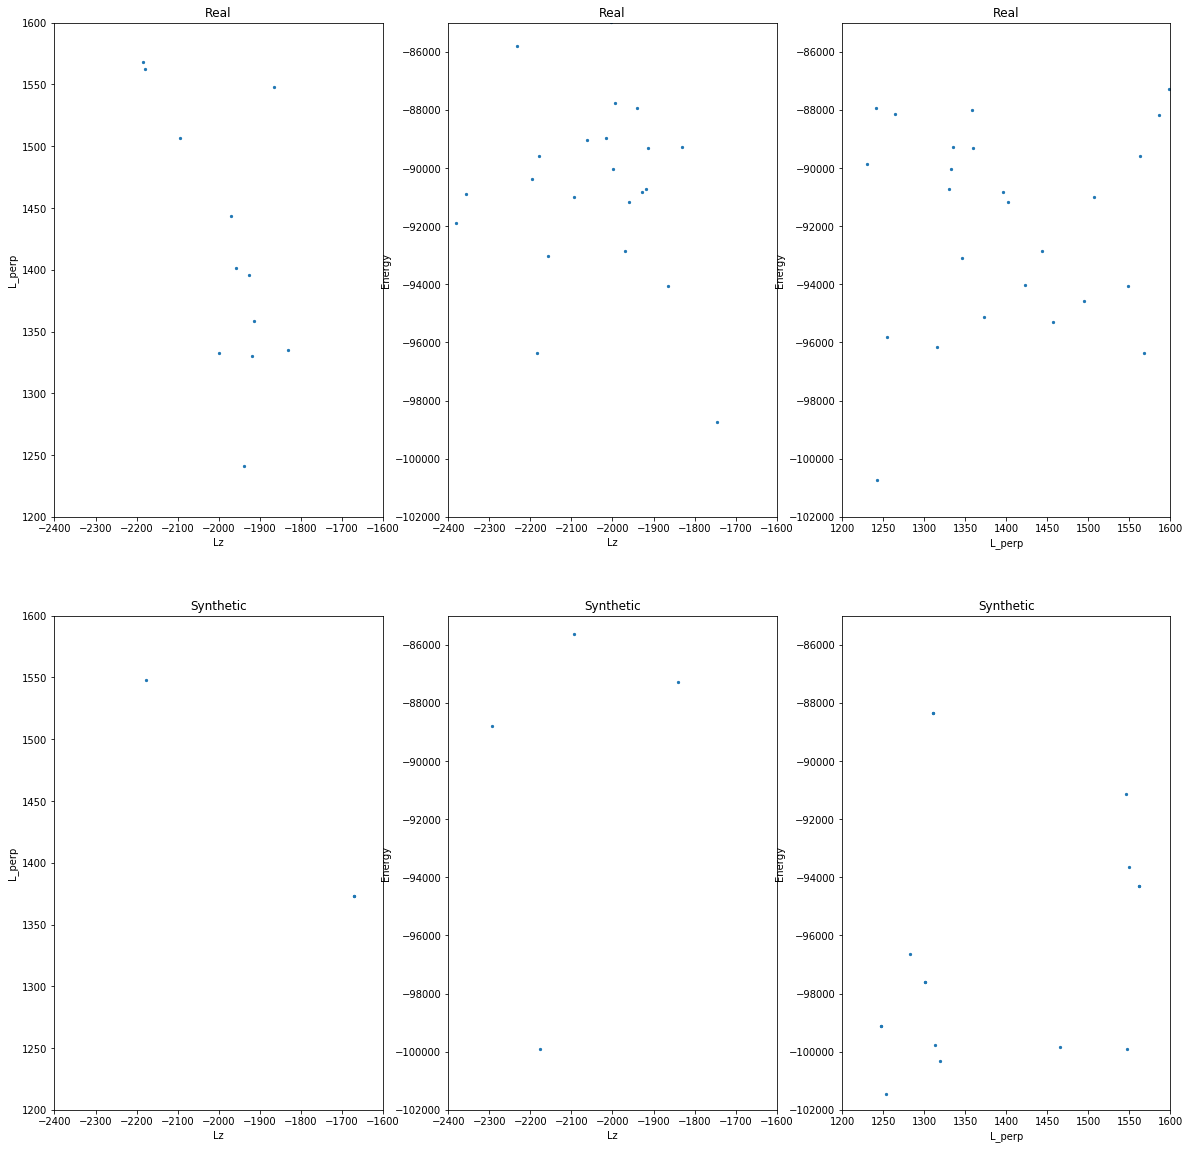

In [11]:
#We construct plots to see where the cluster actually lies
#We then plot a 2d image of each cell along all dimensions to visually inspect the cell volume
plt.figure(figsize=(20,20))

t = t[t['V']<400]
t = t[t['Energy']<0]

#Variables to plot

A = 'Lz'
B = 'L_perp'
C = 'Energy'
D = 'Lz'
E = 'L_perp'
F = 'Energy'

#Lz vs L_perp Real Space
plt.subplot(231)
plt.title('Real')
plt.xlabel(D)
plt.ylabel(E)
plt.ylim(top=upper_bound_L_perp, bottom=lower_bound_L_perp)
plt.xlim(left=lower_bound_Lz, right=upper_bound_Lz)
plt.scatter(t[D],t[E],s=5)
    
#Lz vs Energy Real Space
plt.subplot(232)
plt.title('Real')
plt.xlabel(D)
plt.ylabel(F)
plt.ylim(top=upper_bound_Energy, bottom=lower_bound_Energy)
plt.xlim(left=lower_bound_Lz, right=upper_bound_Lz)
plt.scatter(t[D],t[F],s=5)

#L_perp vs Energy Real Space
plt.subplot(233)
plt.title('Real')
plt.xlabel(E)
plt.ylabel(F)
plt.ylim(top= upper_bound_Energy, bottom=lower_bound_Energy)
plt.xlim(left= lower_bound_L_perp, right=upper_bound_L_perp)
plt.scatter(t[E],t[F],s=5)

#Lz vs L_perp Synthetic Space
plt.subplot(234)
plt.title('Synthetic')
plt.xlabel(D)
plt.ylabel(E)
plt.ylim(top=upper_bound_L_perp, bottom=lower_bound_L_perp)
plt.xlim(left=lower_bound_Lz, right=upper_bound_Lz)
plt.scatter(gsyn[D],gsyn[E],s=5)

#Lz vs Energy Synthetic Space
plt.subplot(235)
plt.title('Synthetic')
plt.xlabel(D)
plt.ylabel(F)
plt.ylim(top=upper_bound_Energy, bottom=lower_bound_Energy)
plt.xlim(left=lower_bound_Lz, right=upper_bound_Lz)
plt.scatter(gsyn[D],gsyn[F],s=5)

#L_perp vs Energy Synthetic Space
plt.subplot(236)
plt.title('Synthetic')
plt.xlabel(E)
plt.ylabel(F)
plt.ylim(top= upper_bound_Energy, bottom=lower_bound_Energy)
plt.xlim(left= lower_bound_L_perp, right=upper_bound_L_perp)
plt.scatter(gsyn[E],gsyn[F],s=5)

plt.show()

#plt.savefig('Cluster_4_Statistical_Verfication.png', dpi = 300, overwrite=True)